<a href="https://colab.research.google.com/github/Sandr001/Data-Mining-MGT7216/blob/main/Copy_of_MGT7216.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [52]:
sales_data = pd.read_csv("/content/drive/MyDrive/Data Mining/sales_data.csv")

# **Handling Data Quality and Formating Issues**

In [14]:
(sales_data).shape

(40000, 13)

In [15]:
sales_data.head(3)

,flag,gender,education,house_val,age,online,marriage,child,occupation,mortgage,house_owner,region,fam_income
0,Y,M,4. Grad,756460,1_Unk,N,NaN,U,Professional,1Low,NaN,Midwest,L
1,N,F,3. Bach,213171,7_>65,N,NaN,U,Professional,1Low,Owner,Northeast,G
2,N,M,2. Some College,111147,2_<=25,Y,NaN,Y,Professional,1Low,Owner,Midwest,J


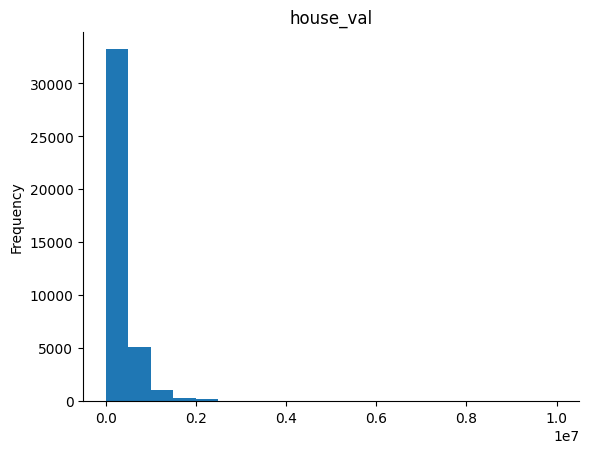

In [16]:
# @title house_val

from matplotlib import pyplot as plt
sales_data['house_val'].plot(kind='hist', bins=20, title='house_val')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
sales_data.columns

Index(['flag', 'gender', 'education', 'house_val', 'age', 'online', 'marriage',
       'child', 'occupation', 'mortgage', 'house_owner', 'region',
       'fam_income'],
      dtype='object')

In [18]:
for column in sales_data.columns:
  if sales_data[column].dtype == "O":
    print(f"{column}: {sales_data[column].unique()}\n")

flag: ['Y' 'N']

gender: ['M' 'F' 'U']

education: ['4. Grad' '3. Bach' '2. Some College' '1. HS' '0. <HS' nan]

age: ['1_Unk' '7_>65' '2_<=25' '6_<=65' '5_<=55' '4_<=45' '3_<=35']

online: ['N' 'Y']

marriage: [nan 'Single' 'Married']

child: ['U' 'Y' 'N' '0']

occupation: ['Professional' 'Sales/Service' 'Blue Collar' 'Others' 'Retired' 'Farm']

mortgage: ['1Low' '2Med' '3High']

house_owner: [nan 'Owner' 'Renter']

region: ['Midwest' 'Northeast' 'West' 'South' 'Rest']

fam_income: ['L' 'G' 'J' 'H' 'C' 'I' 'D' 'E' 'A' 'F' 'B' 'K' 'U']



In [19]:
na_counts = sales_data.isna().sum()
na_counts

flag               0
gender             0
education        741
house_val          0
age                0
online             0
marriage       14027
child              0
occupation         0
mortgage           0
house_owner     3377
region             0
fam_income         0
dtype: int64

In [20]:
for column in sales_data.columns:
  if sales_data[column].dtype == "O":
    subcategory_count = sales_data[column].value_counts()
    print(subcategory_count)


Y    20000
N    20000
Name: flag, dtype: int64
M    22019
F    16830
U     1151
Name: gender, dtype: int64
2. Some College    11400
3. Bach             9267
1. HS               8828
4. Grad             5916
0. <HS              3848
Name: education, dtype: int64
5_<=55    8103
4_<=45    7115
1_Unk     6709
6_<=65    5907
3_<=35    4984
7_>65     4822
2_<=25    2360
Name: age, dtype: int64
Y    27319
N    12681
Name: online, dtype: int64
Married    20891
Single      5082
Name: marriage, dtype: int64
Y    18012
N    13333
U     8528
0      127
Name: child, dtype: int64
Professional     14936
Sales/Service    11767
Blue Collar       6621
Retired           4341
Others            2006
Farm               329
Name: occupation, dtype: int64
1Low     29848
3High     5349
2Med      4803
Name: mortgage, dtype: int64
Owner     29232
Renter     7391
Name: house_owner, dtype: int64
South        15676
West          8725
Midwest       8107
Northeast     7247
Rest           245
Name: region, dtype: int6

In [62]:
sales_data_v2 = sales_data.copy()

In [63]:
# Mapping dictionary for replacements
education_mapping = {
    '4. Grad': 'Graduation',
    '3. Bach': 'Bachelors',
    '2. Some College': 'College',
    '1. HS': 'High School',
    '0. <HS': 'Below High School'
}

# Replace values in 'education' column based on mapping dictionary
sales_data_v2['education'] = sales_data_v2['education'].map(education_mapping)

# Impute remaining missing values with 'Unknown'
sales_data_v2['education'].fillna('Unknown', inplace=True)

# Display the updated DataFrame
print(sales_data_v2['education'].unique())


['Graduation' 'Bachelors' 'College' 'High School' 'Below High School'
 'Unknown']


In [64]:
sales_data_v2['age'] = (sales_data_v2['age'].str.split('_').str[0]).astype('Int64')
sales_data_v2['age'].unique()


<IntegerArray>
[1, 7, 2, 6, 5, 4, 3]
Length: 7, dtype: Int64

In [65]:
# sales_data_v2['mortgage'] = sales_data_v2['mortgage'].str.replace(r'\d+', '', regex=True)
# # Replace 'Med' with 'Medium' in the 'mortgage' column
# sales_data_v2.loc[sales_data_v2['mortgage'] == 'Med', 'mortgage'] = 'Medium'
# sales_data_v2['mortgage'].unique()

for mortgage in sales_data_v2['mortgage'].unique():
    level = re.findall(r'\d+', mortgage)[0]
    sales_data_v2['mortgage'].replace(mortgage, level, inplace=True)

sales_data_v2['mortgage'] = sales_data_v2['mortgage'].astype('Int64')
sales_data_v2['mortgage'].unique()

<IntegerArray>
[1, 2, 3]
Length: 3, dtype: Int64

In [66]:
# Define a dictionary mapping alphabetical rankings to numerical rankings
ranking = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'U': 0}

# Map alphabetical rankings to numerical rankings
sales_data_v2['fam_income'] = sales_data_v2['fam_income'].map(ranking)

In [67]:
# Replace '0' with 'N' in the 'child' column
sales_data_v2['child'] = sales_data_v2['child'].replace({'0': 'N'})

In [68]:
# Impute missing values in 'married' column based on 'child' column
sales_data_v2['marriage'] = sales_data_v2.apply(lambda row: 'Married/Single Parent' if pd.isnull(row['marriage']) and row['child'] == 'Y' else row['marriage'], axis=1)

# Impute remaining missing values with 'Unknown'
sales_data_v2['marriage'].fillna('Unknown', inplace=True)

# Display the updated DataFrame
print(sales_data_v2['marriage'].unique())

['Unknown' 'Married/Single Parent' 'Single' 'Married']


In [69]:
# Impute remaining missing values in house_owner with 'Unknown'
sales_data_v2['house_owner'].fillna('Unknown', inplace=True)

# Display the updated DataFrame
print(sales_data_v2['house_owner'].unique())

['Unknown' 'Owner' 'Renter']


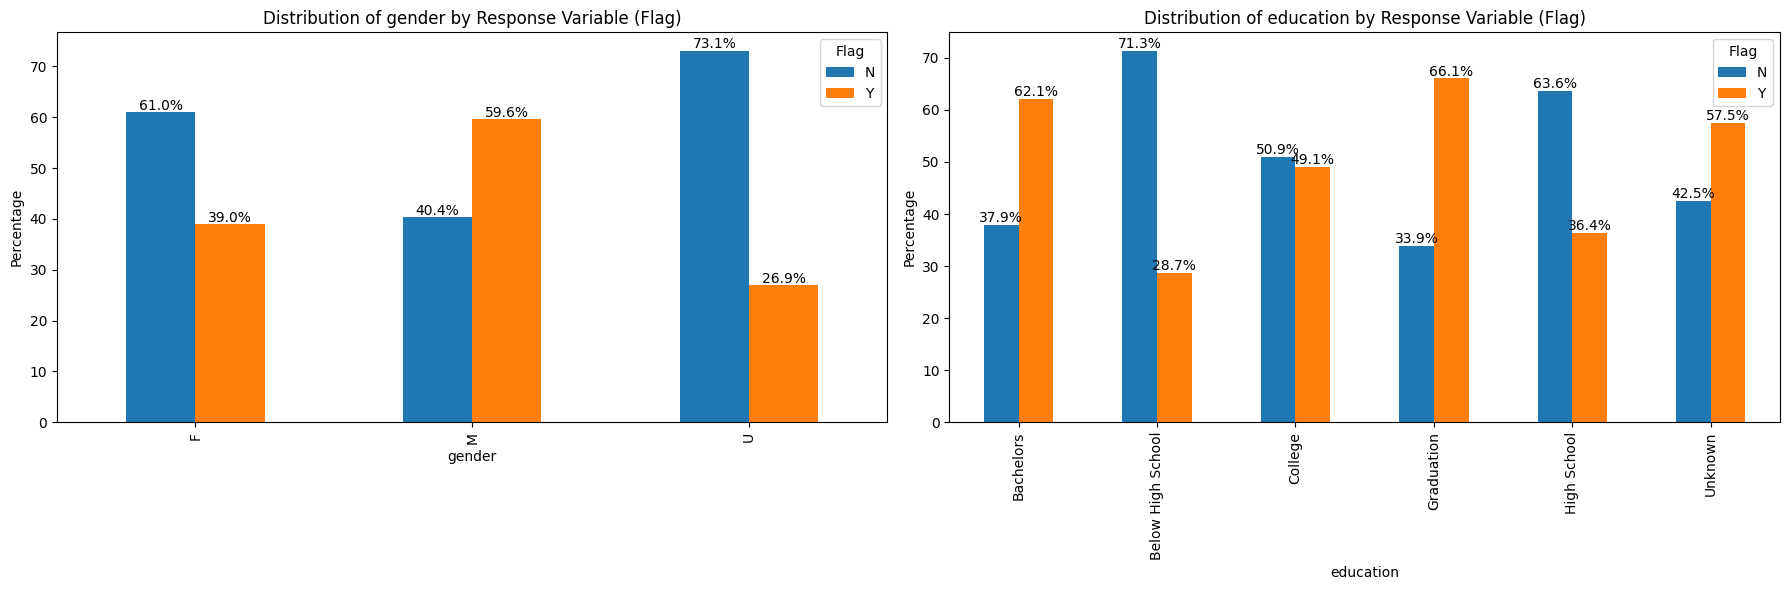

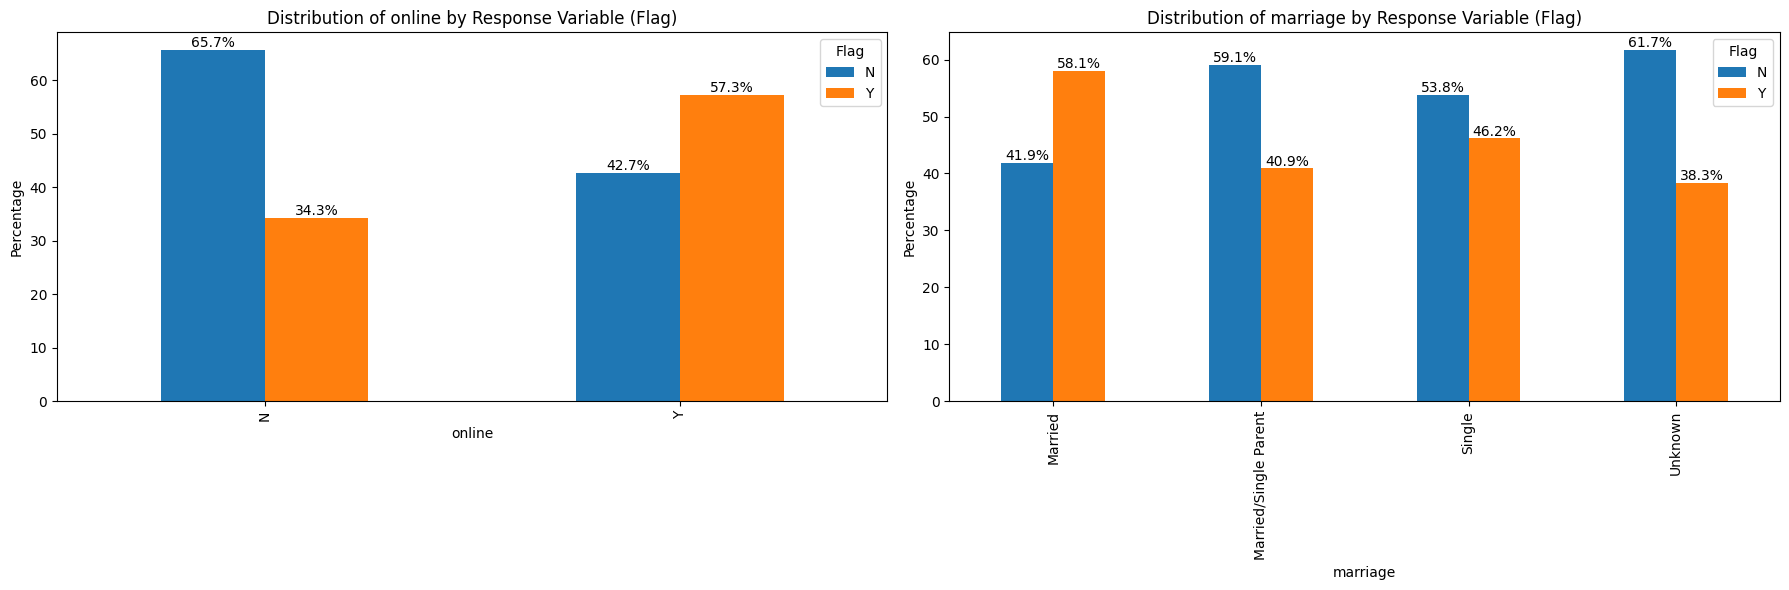

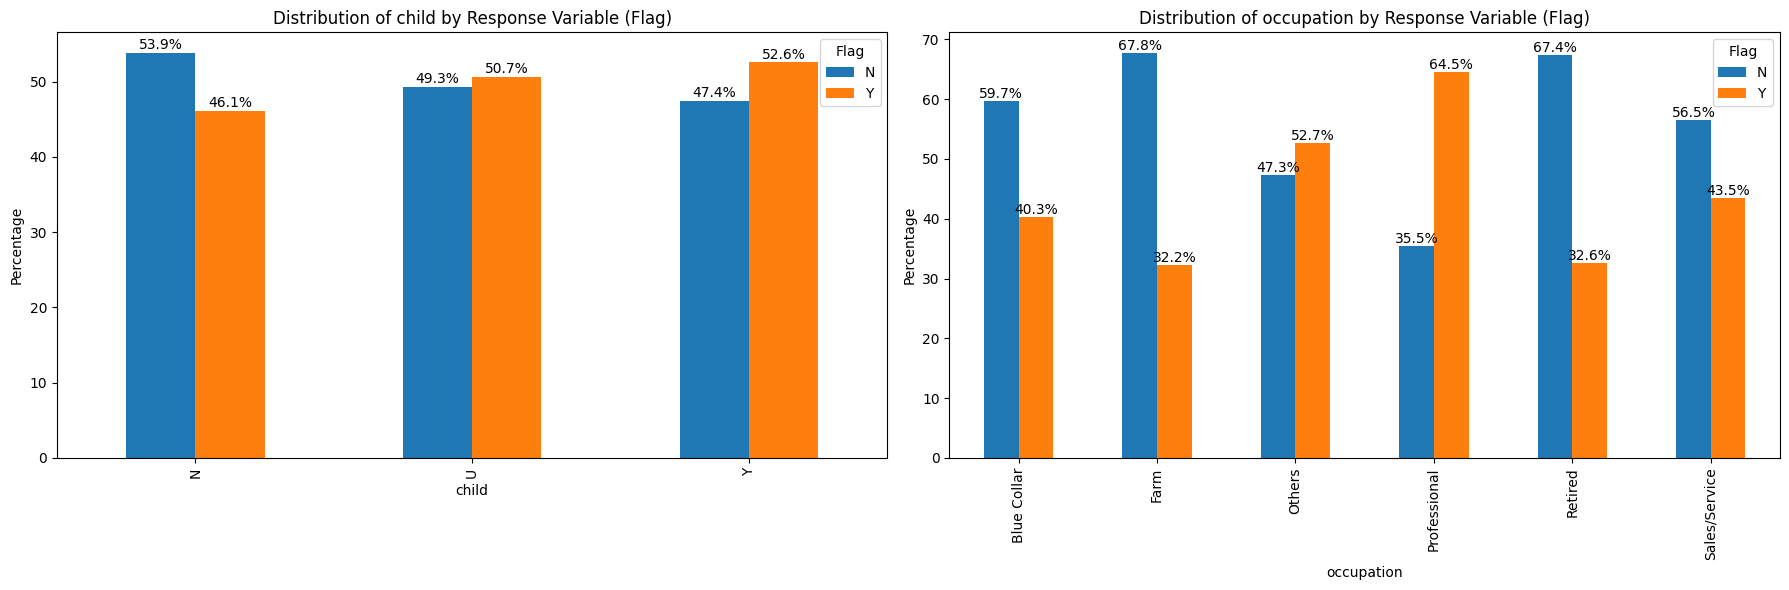

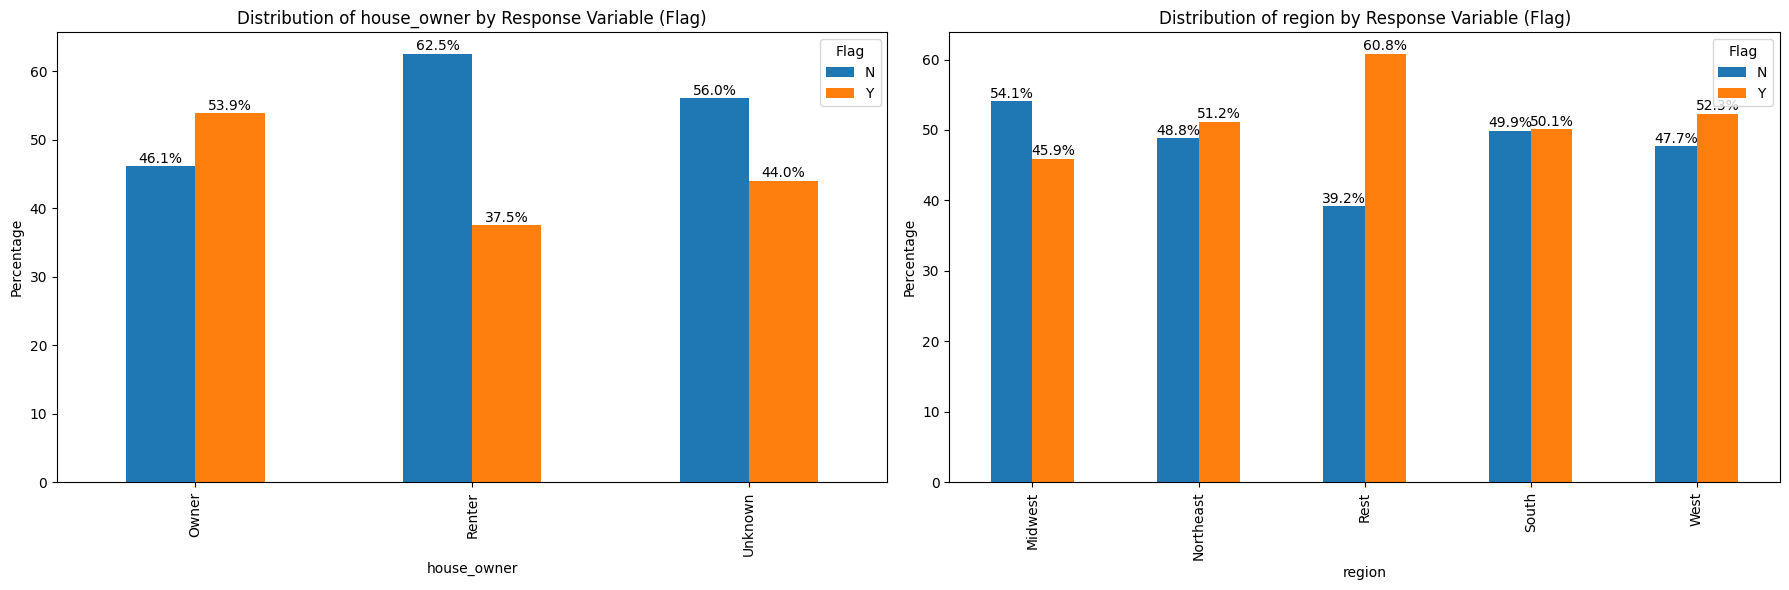

In [30]:

# Function to add percentage annotations on top of each bar
def add_percentage_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5,
                '{:.1f}%'.format(height),
                ha='center')

# Countplot of Categorical Predictors by Response Variable (as percentages)
categorical_predictors = ['gender', 'education', 'online', 'marriage', 'child', 'occupation', 'house_owner', 'region']
for i in range(0, len(categorical_predictors), 2):  # Iterate over predictors in steps of 2
    plt.figure(figsize=(18, 6))

    # Plot the first count plot
    plt.subplot(1, 2, 1)
    counts = sales_data_v2.groupby([categorical_predictors[i], 'flag']).size().unstack()
    (counts.div(counts.sum(axis=1), axis=0) * 100).plot(kind='bar', ax=plt.gca())
    plt.title(f'Distribution of {categorical_predictors[i]} by Response Variable (Flag)')
    plt.xlabel(categorical_predictors[i])
    plt.ylabel('Percentage')
    plt.legend(title='Flag')
    add_percentage_labels(plt.gca())

    # Plot the second count plot if available
    if i + 1 < len(categorical_predictors):
        plt.subplot(1, 2, 2)
        counts = sales_data_v2.groupby([categorical_predictors[i + 1], 'flag']).size().unstack()
        (counts.div(counts.sum(axis=1), axis=0) * 100).plot(kind='bar', ax=plt.gca())
        plt.title(f'Distribution of {categorical_predictors[i + 1]} by Response Variable (Flag)')
        plt.xlabel(categorical_predictors[i + 1])
        plt.ylabel('Percentage')
        plt.legend(title='Flag')
        add_percentage_labels(plt.gca())

    plt.tight_layout()
    plt.show()


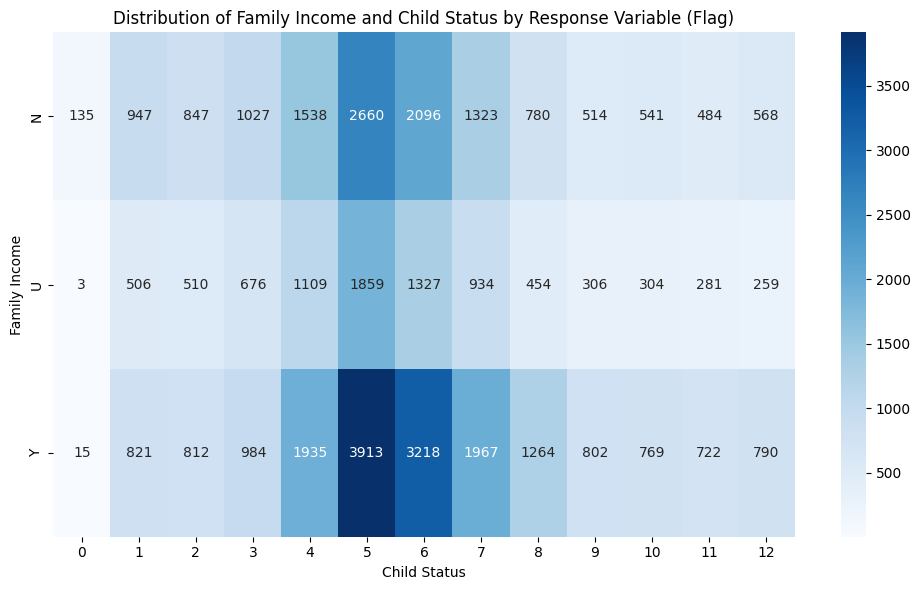

In [31]:
# Create a pivot table to aggregate counts of flag based on fam_income and child
pivot_table = sales_data_v2.pivot_table(index='child', columns='fam_income',
                                       values='flag', aggfunc='count', fill_value=0)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues')
plt.title('Distribution of Family Income and Child Status by Response Variable (Flag)')
plt.xlabel('Child Status')
plt.ylabel('Family Income')
plt.tight_layout()
plt.show()


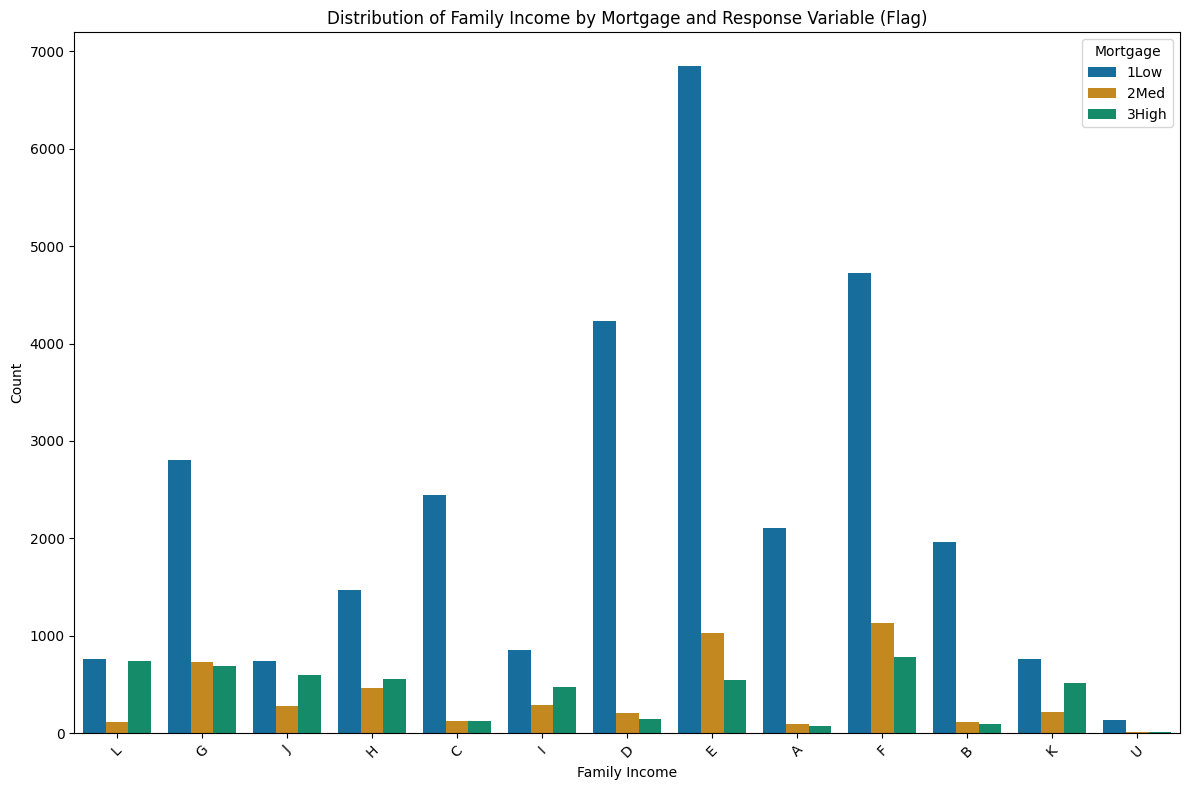

In [158]:

# Grouped bar plot for fam_income with flag (response variable), grouped by mortgage
plt.figure(figsize=(12, 8))
sns.countplot(x='fam_income', hue='mortgage', data=sales_data, palette='colorblind')
plt.title('Distribution of Family Income by Mortgage and Response Variable (Flag)')
plt.xlabel('Family Income')
plt.ylabel('Count')
plt.legend(title='Mortgage', loc='upper right')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


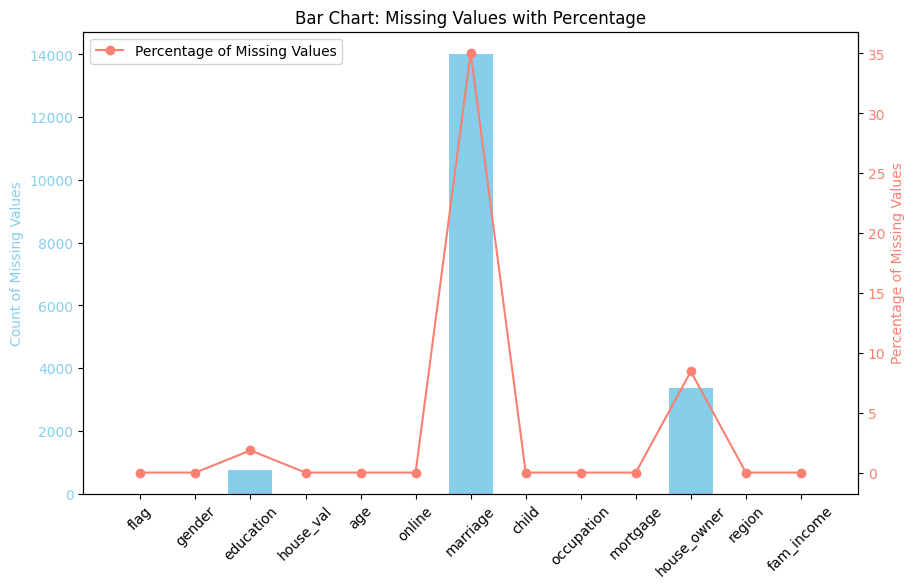


Missing Information:
flag               0
gender             0
education        741
house_val          0
age                0
online             0
marriage       14027
child              0
occupation         0
mortgage           0
house_owner     3377
region             0
fam_income         0
dtype: int64

Missing Information(%):
flag            0.0000
gender          0.0000
education       1.8525
house_val       0.0000
age             0.0000
online          0.0000
marriage       35.0675
child           0.0000
occupation      0.0000
mortgage        0.0000
house_owner     8.4425
region          0.0000
fam_income      0.0000
dtype: float64


In [159]:
import matplotlib.pyplot as plt

# Missing information
missing_info = sales_data.isnull().sum()

# Calculate missing percentage
missing_percentage = 100 * sales_data.isnull().sum() / len(sales_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Actual count of missing values (left y-axis)
color = 'skyblue'
ax1.bar(sales_data.columns, sales_data.isnull().sum(), color=color, label='Count of Missing Values')
ax1.set_ylabel('Count of Missing Values', color=color)
ax1.tick_params(axis='y', labelcolor=color)
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Percentage of missing values (right y-axis)
ax2 = ax1.twinx()
color = 'salmon'
ax2.plot(sales_data.columns, missing_percentage, color=color, marker='o', label='Percentage of Missing Values')
ax2.set_ylabel('Percentage of Missing Values', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and labels
plt.title('Bar Chart: Missing Values with Percentage')
plt.xlabel('Variables')
plt.legend(loc='upper left')

plt.show()

print("\n\033[1mMissing Information:\033[0m")
print(missing_info)

print("\n\033[1mMissing Information(%):\033[0m")
print(missing_percentage)


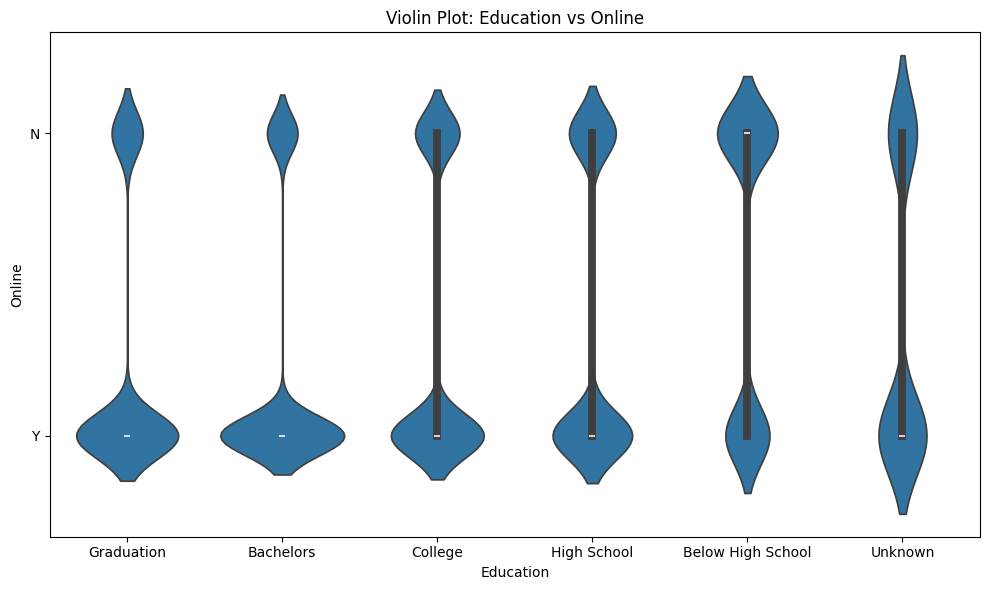

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a violin plot for education vs online
plt.figure(figsize=(10, 6))
sns.violinplot(x='education', y='online', data=sales_data_v2)
plt.title('Violin Plot: Education vs Online')
plt.xlabel('Education')
plt.ylabel('Online')
plt.tight_layout()
plt.show()


In [161]:
# Create a cross-tabulation table
cross_tab = pd.crosstab(sales_data_v2['education'], sales_data_v2['online'])

# Display the cross-tabulation table
print("Cross-Tabulation Table: Education vs Online")
print(cross_tab)

Cross-Tabulation Table: Education vs Online
online                N     Y
education                    
Bachelors          1836  7431
Below High School  2226  1622
College            3689  7711
Graduation         1382  4534
High School        3270  5558
Unknown             278   463


# **Random Forest Classifier Model**

In [70]:
# Map 'Y' to 1 and 'N' to 0
sales_data_v2['flag'] = sales_data_v2['flag'].map({'Y': 1, 'N': 0})

# Assuming 'data' is your DataFrame containing categorical variables
design_matrix = pd.get_dummies(sales_data_v2)

design_matrix.columns

Index(['flag', 'house_val', 'age', 'mortgage', 'fam_income', 'gender_F',
       'gender_M', 'gender_U', 'education_Bachelors',
       'education_Below High School', 'education_College',
       'education_Graduation', 'education_High School', 'education_Unknown',
       'online_N', 'online_Y', 'marriage_Married',
       'marriage_Married/Single Parent', 'marriage_Single', 'marriage_Unknown',
       'child_N', 'child_U', 'child_Y', 'occupation_Blue Collar',
       'occupation_Farm', 'occupation_Others', 'occupation_Professional',
       'occupation_Retired', 'occupation_Sales/Service', 'house_owner_Owner',
       'house_owner_Renter', 'house_owner_Unknown', 'region_Midwest',
       'region_Northeast', 'region_Rest', 'region_South', 'region_West'],
      dtype='object')

**Assignment: Features and Target variable**

In [71]:
# Features and target variable
X = design_matrix.drop('flag', axis=1)
y = design_matrix['flag']

**Split the data into Train and Test sets**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Define the Random Forest Classifier and its default Hyperparameter values**

In [73]:
clf = RandomForestClassifier(random_state=42, oob_score=True)

print("Default hyperparameter values:")
print(clf.get_params())

Default hyperparameter values:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


**Fit the Model and Display the Performance Metrics**

In [75]:
y_pred_before_tuning = clf.fit(X_train, y_train).predict(X_test)
report_before_tuning = classification_report(y_test, y_pred_before_tuning)
print("Performance Metrics Before Hyperparameter Tuning:")
print(report_before_tuning)

# Calculate the out-of-bag score
oob_score = clf.oob_score_
print(f'OOB Score: {oob_score}')


Performance Metrics Before Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4024
           1       0.66      0.65      0.66      3976

    accuracy                           0.66      8000
   macro avg       0.66      0.66      0.66      8000
weighted avg       0.66      0.66      0.66      8000

OOB Score: 0.6606875


# **Model Performance Evaluation Plots**

**Predicted Probabilities**

In [76]:
y_score = clf.predict_proba(X_test)[:, 1]
y_score

array([0.73 , 0.34 , 0.41 , ..., 0.885, 0.19 , 0.23 ])

**ROC-Curve and ROC-Area**

In [77]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

roc_auc

0.7213345305430996

**Precision-Recall Curve and Average Precision**

In [78]:
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

**Compute Lift Curve**

In [181]:
lift_values = []
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    lift_values.append(np.mean(y_pred) / np.mean(y_test))

**Compute F1-Score Curve**

In [183]:
f1_scores = []
for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

**Confusion Matrix**

In [182]:
y_pred_binary = (y_score >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

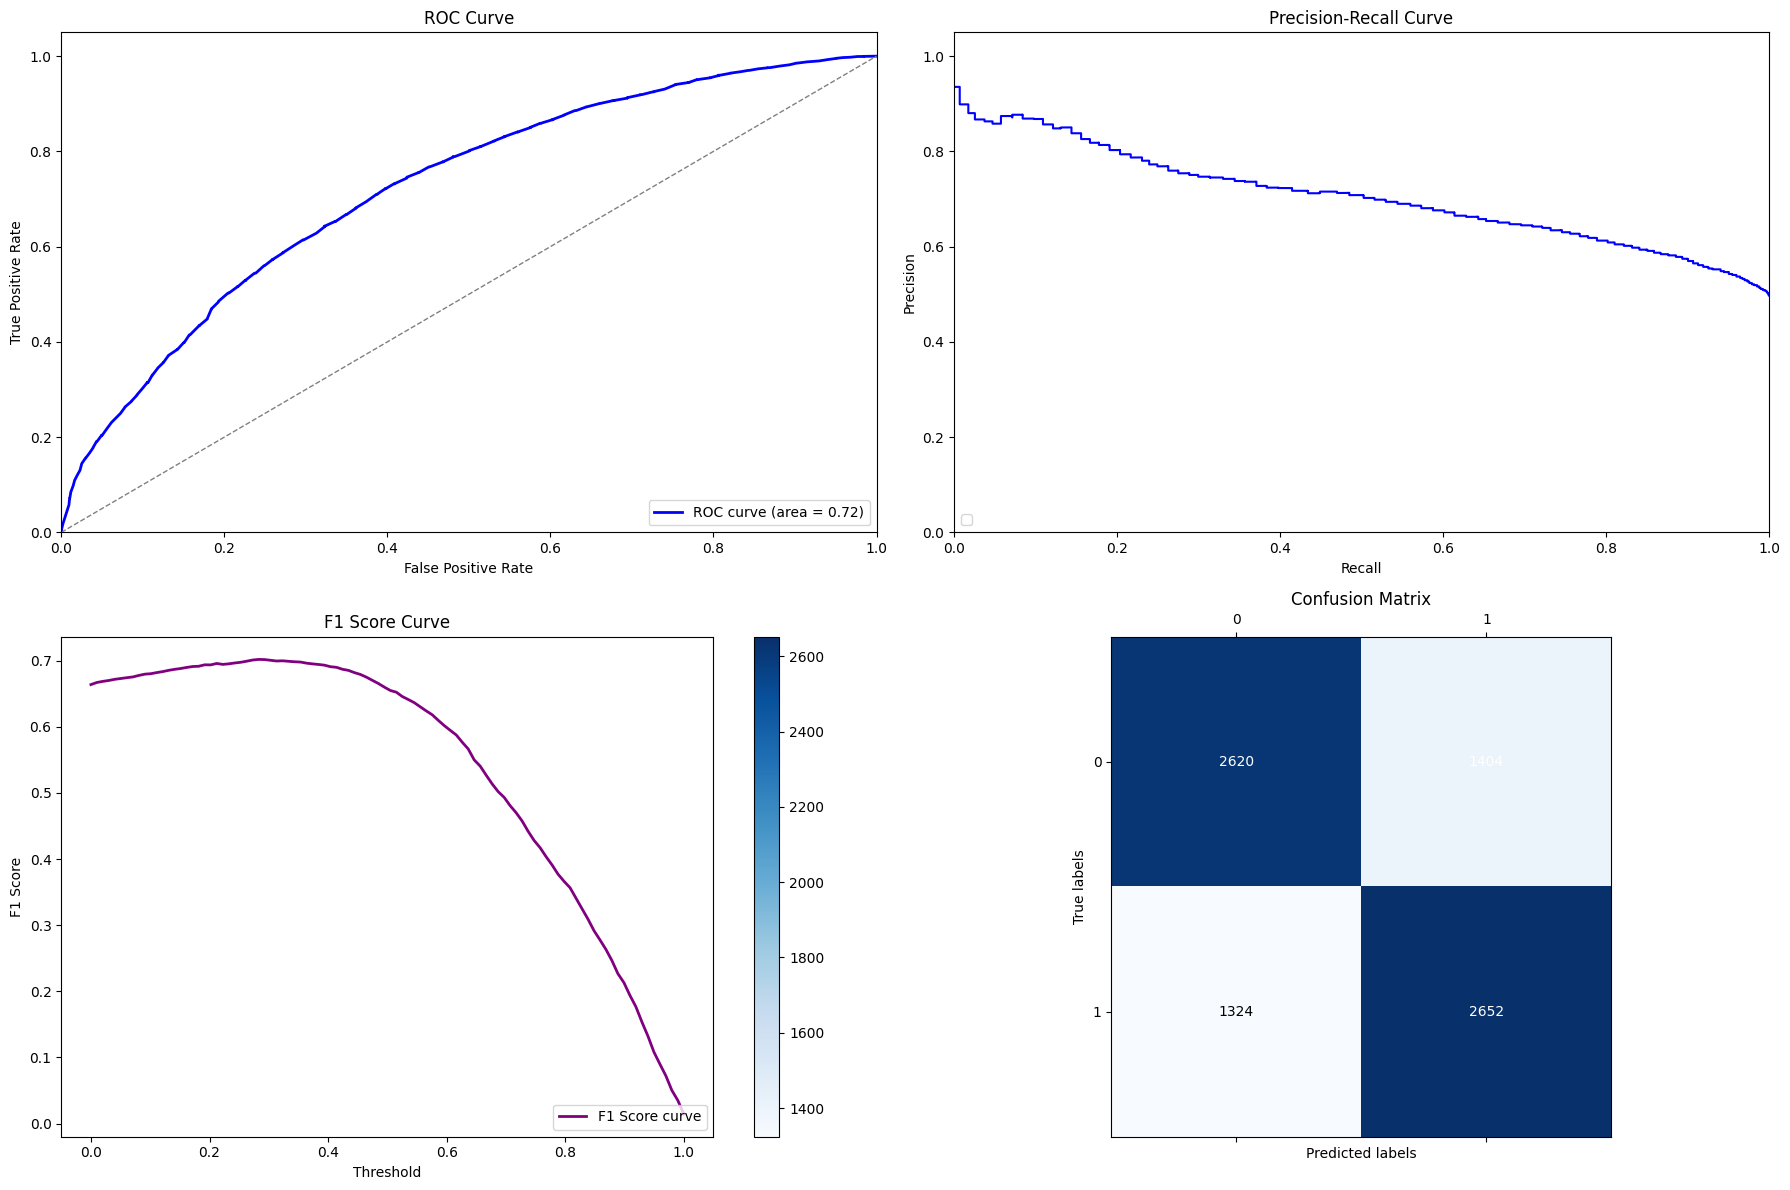

In [199]:
# Create a panel of plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot the ROC Curve
axes[0, 0].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")

# Plot the Precision-Recall Curve
axes[0, 1].step(recall, precision, color='blue', where='post')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].legend(loc="lower left")

# Plot the F1 Score Curve
axes[1, 0].plot(thresholds, f1_scores, color='purple', lw=2, label='F1 Score curve')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score Curve')
axes[1, 0].legend(loc="lower right")

# Plot the Confusion Matrix
conf_matrix_img = axes[1, 1].matshow(conf_matrix, cmap=plt.cm.Blues)
axes[1, 1].set_title('Confusion Matrix')
plt.colorbar(conf_matrix_img, ax=axes[1, 0])
axes[1, 1].set_xlabel('Predicted labels')
axes[1, 1].set_ylabel('True labels')

# Add Text Annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[1, 1].text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2. else "black")


plt.tight_layout() # Adjust the layout
plt.show() # Show the plot panel

In [82]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', clf)
])

In [83]:
param_grid = {
    'clf__n_estimators': [1000, 2000],
    'clf__max_depth': [None, 10, 20]
    # 'clf__min_samples_split': [2, 5],
    # 'clf__min_samples_leaf': [1, 2]
}

In [84]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('clf',
                                        RandomForestClassifier(oob_score=True,
                                                               random_state=42))]),
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__n_estimators': [1000, 2000]},
             scoring='accuracy')

In [85]:
best_clf = grid_search.best_estimator_
print(best_clf)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=1000,
                                        oob_score=True, random_state=42))])


In [86]:
y_pred_after_tuning = best_clf.predict(X_test)
report_after_tuning = classification_report(y_test, y_pred_after_tuning)
print("\nPerformance Metrics After Hyperparameter Tuning:")
print(report_after_tuning)


Performance Metrics After Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4024
           1       0.69      0.69      0.69      3976

    accuracy                           0.69      8000
   macro avg       0.69      0.69      0.69      8000
weighted avg       0.69      0.69      0.69      8000



In [87]:
# Get the predicted probabilities
y_score = best_clf.predict_proba(X_test)[:, 1]

# Compute the ROC Curve and ROC Area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Compute the Precision-Recall Curve and Average Precision
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

# Compute the Lift Curve
lift_values = []
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    lift_values.append(np.mean(y_pred) / np.mean(y_test))

# Compute the F1 Score Curve
f1_scores = []
for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

# Compute the Confusion Matrix
y_pred_binary = (y_score >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)



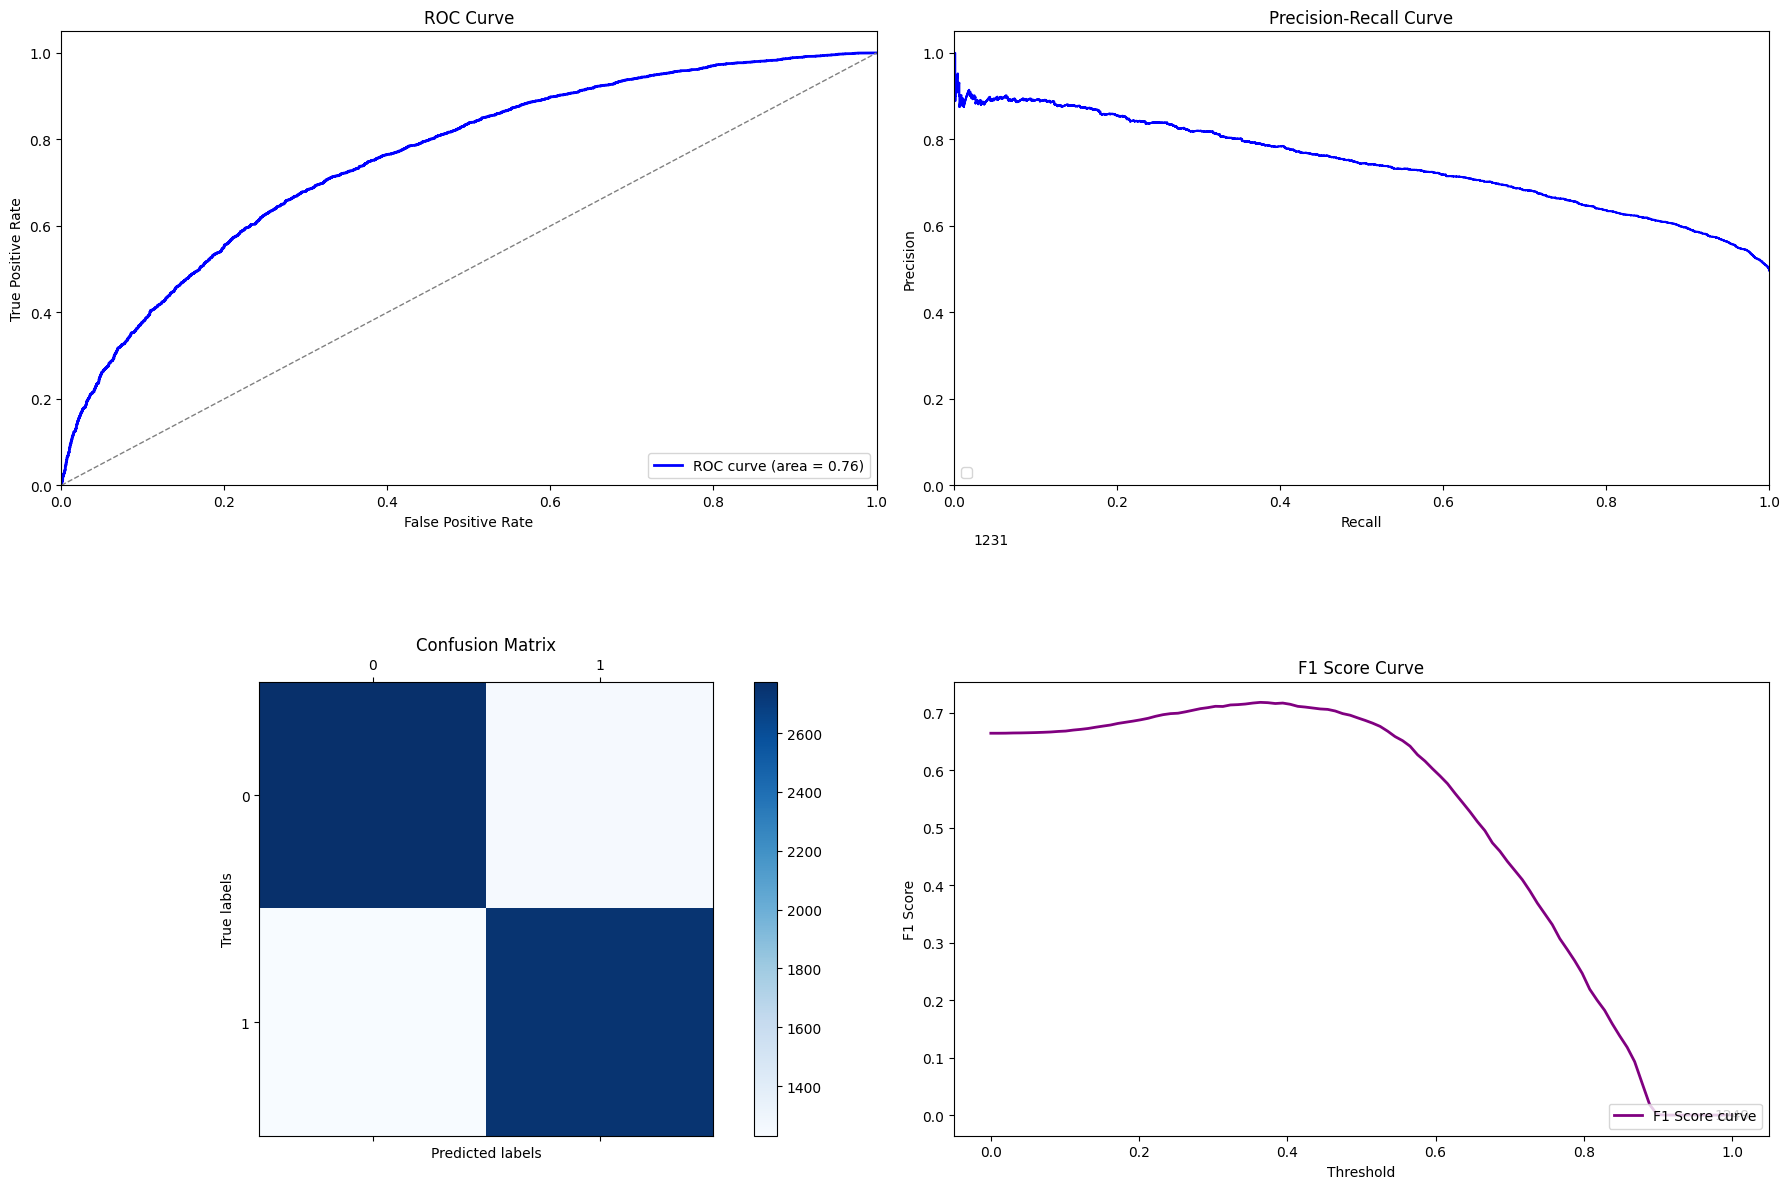

In [38]:
# Create a panel of plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot the ROC Curve
axes[0, 0].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")

# Plot the Precision-Recall Curve
axes[0, 1].step(recall, precision, color='blue', where='post')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].legend(loc="lower left")

# Plot the Confusion Matrix
conf_matrix_img = axes[1, 0].matshow(conf_matrix, cmap=plt.cm.Blues)
axes[1, 0].set_title('Confusion Matrix')
plt.colorbar(conf_matrix_img, ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted labels')
axes[1, 0].set_ylabel('True labels')

# Add Text Annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[1, 1].text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2. else "black")

# Plot the F1 Score Curve
axes[1, 1].plot(thresholds, f1_scores, color='purple', lw=2, label='F1 Score curve')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score Curve')
axes[1, 1].legend(loc="lower right")



plt.tight_layout()
plt.show()

#**Support Vector Machine Model Classifier**

In [88]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [89]:
design_matrix = pd.get_dummies(sales_data_v2)
design_matrix.columns

# Features and target variable
X = design_matrix.drop('flag', axis=1)
y = design_matrix['flag']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
# Create an SVM classifier
svm_classifier = svm.SVC(random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy: 0.485375


In [93]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3645  379]
 [3738  238]]
              precision    recall  f1-score   support

           0       0.49      0.91      0.64      4024
           1       0.39      0.06      0.10      3976

    accuracy                           0.49      8000
   macro avg       0.44      0.48      0.37      8000
weighted avg       0.44      0.49      0.37      8000



In [17]:
classifier = svm.SVC(random_state=42)

In [24]:
hyperparameters = {
                   'kernel': ['linear'],
                   'C': [0.01, 0.1],
                   'gamma': [0.01, 0.1]}

In [25]:
grid_search = GridSearchCV(classifier, hyperparameters, cv=5) #scoring='roc_auc'
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1], 'gamma': [0.01, 0.1],
                         'kernel': ['linear']})

In [26]:
best_classifier = grid_search.best_estimator_
print(best_classifier,'\n')
y_pred = best_classifier.predict(X_test_scaled)

SVC(C=0.01, gamma=0.01, kernel='linear') 



In [27]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2730 1294]
 [1289 2687]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4024
           1       0.67      0.68      0.68      3976

    accuracy                           0.68      8000
   macro avg       0.68      0.68      0.68      8000
weighted avg       0.68      0.68      0.68      8000



<Axes: >

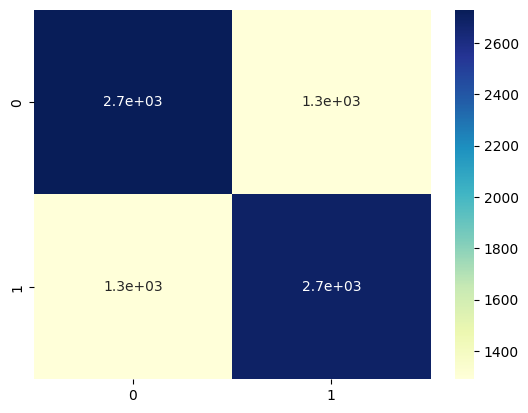

In [28]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu")

house_val                         0.057260
age                               0.283839
mortgage                          0.273770
fam_income                        0.161758
gender_F                         -0.230976
gender_M                          0.501754
gender_U                         -0.270778
education_Bachelors               0.165437
education_Below High School      -0.441156
education_College                -0.070950
education_Graduation              0.262678
education_High School            -0.378390
education_Unknown                 0.462381
online_N                         -0.346475
online_Y                          0.346475
marriage_Married                  0.197087
marriage_Married/Single Parent   -0.251961
marriage_Single                   0.257767
marriage_Unknown                 -0.202892
child_N                          -0.175003
child_U                           0.090721
child_Y                           0.084282
occupation_Blue Collar           -0.114518
occupation_

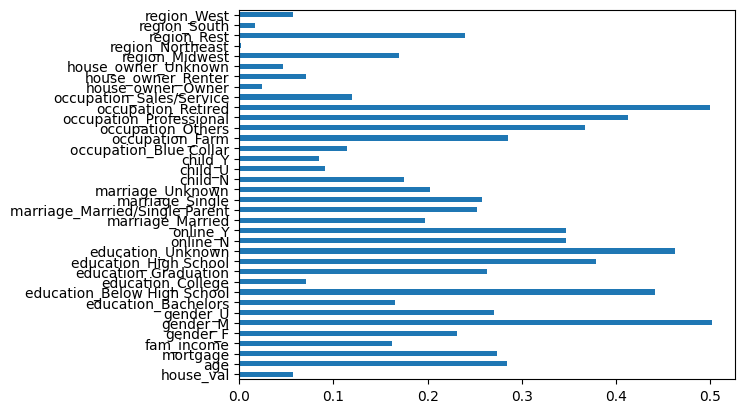

In [39]:
import matplotlib.pyplot as plt
importances = pd.Series(best_classifier.coef_[0], index=X_train.columns)
print(importances,'\n')
importances=abs(importances)
print(importances,'\n')
importances.plot(kind='barh')
plt.show()

[[ 0.05725975  0.28383883  0.27376972  0.16175769 -0.23097599  0.50175354
  -0.27077755  0.16543719 -0.441156   -0.07095011  0.26267809 -0.37838997
   0.4623808  -0.34647496  0.34647496  0.19708666 -0.2519613   0.25776663
  -0.20289199 -0.17500278  0.0907208   0.08428198 -0.11451794 -0.28554798
   0.36751438  0.41240747 -0.4997696   0.11991367  0.02419827 -0.07062118
   0.04642291 -0.16917536  0.00215785  0.24       -0.01634868 -0.05663381]] 

[[0.05725975 0.28383883 0.27376972 0.16175769 0.23097599 0.50175354
  0.27077755 0.16543719 0.441156   0.07095011 0.26267809 0.37838997
  0.4623808  0.34647496 0.34647496 0.19708666 0.2519613  0.25776663
  0.20289199 0.17500278 0.0907208  0.08428198 0.11451794 0.28554798
  0.36751438 0.41240747 0.4997696  0.11991367 0.02419827 0.07062118
  0.04642291 0.16917536 0.00215785 0.24       0.01634868 0.05663381]] 



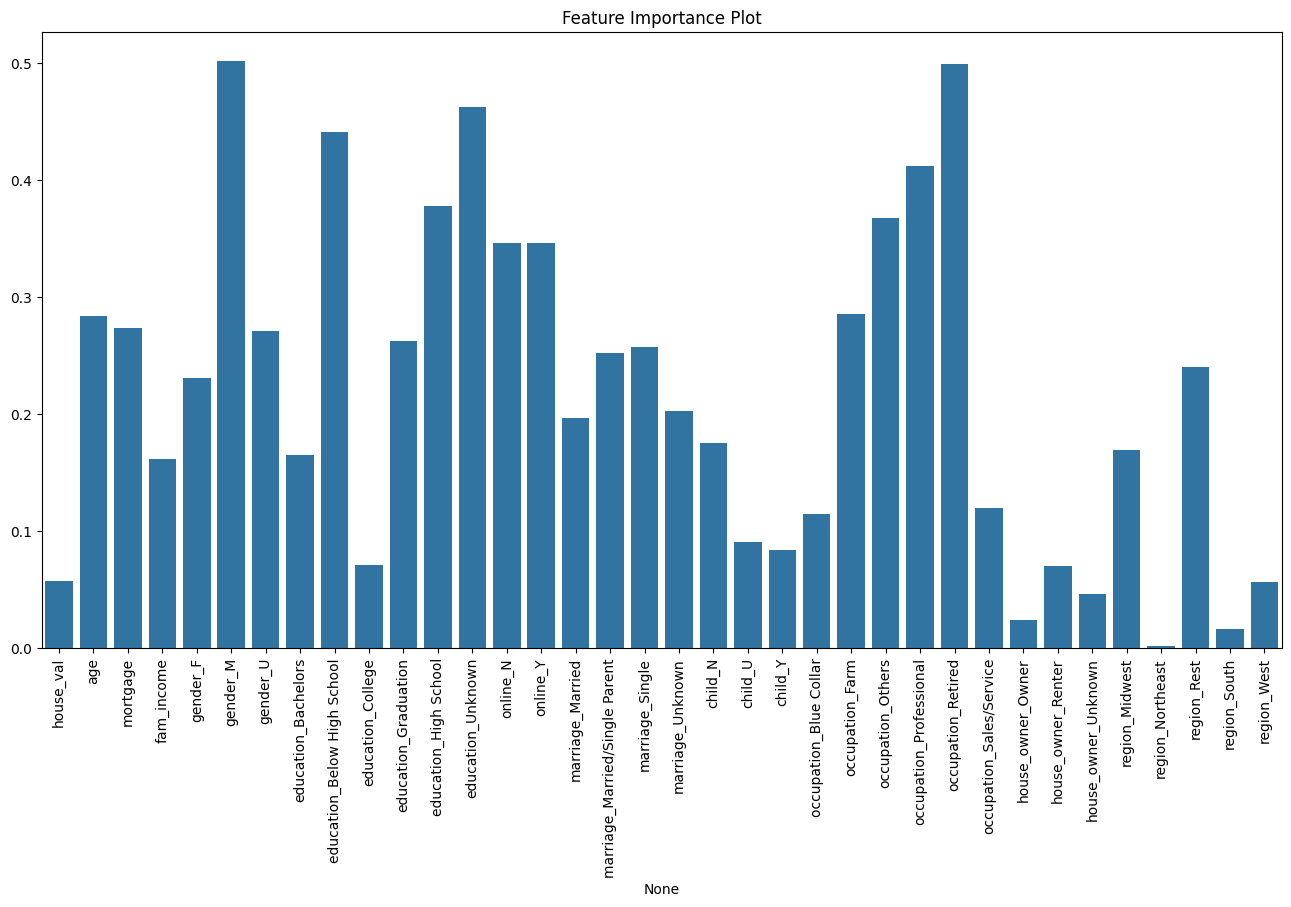

In [38]:
# Print the coefficients of the hyperplane
coefficients = best_classifier.coef_
print(coefficients,'\n')
coefficients = abs(coefficients)
print(coefficients,'\n')
# Display the coefficients
#import matplotlib.pyplot as plt
#%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=X_train.columns, y=coefficients.reshape(-1))
ax.set_title("Feature Importance Plot")
# Rotate the y-axis labels by 45 degrees
plt.xticks(rotation=90)
plt.show()